In [1]:
import cv2
import numpy as np
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
zip_file_path = 'Masks.zip'
extracted_folder_path = '/mnt/data/Masks'
img_size = (128, 128)

In [3]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

masks_dir_path = os.path.join(extracted_folder_path, 'Masks')
mask_files = os.listdir(masks_dir_path)


In [4]:
labels = [1 if img in [
    'Female 7.6_1 mask.jpeg',
    'Female 8.0_2 mask.jpeg',
    'Female 8.7_3 mask.jpg',
    'Female 10.6_2 mask.jpeg',
    'Female 13.7_4 mask.jpg'
] else 0 for img in mask_files]

In [5]:
def extract_age_from_filename(filename):
    age_part = filename.split(' ')[1]
    years, months = map(int, age_part.split('_')[0].split('.'))
    return years + months / 12.0

In [6]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  
    img = preprocess_input(img)  
    return img

image_paths = [os.path.join(masks_dir_path, img) for img in mask_files]
ages = [extract_age_from_filename(img) for img in mask_files]
images = np.array([load_and_preprocess_image(path) for path in image_paths])
ages = np.array(ages)
labels = np.array(labels)


In [7]:
def augment_image(img):
    augmented_images = []
    for angle in range(-20, 21, 10):  
        M = cv2.getRotationMatrix2D((img_size[0] // 2, img_size[1] // 2), angle, 1)
        rotated = cv2.warpAffine(img, M, img_size)
        augmented_images.append(rotated)
    flipped_h = cv2.flip(img, 1) 
    flipped_v = cv2.flip(img, 0) 
    augmented_images.extend([flipped_h, flipped_v])
    return augmented_images

augmented_images = []
augmented_ages = []
original_labels = []

for img, age, label in zip(images, ages, labels):
    augmented = augment_image(img)
    augmented_images.extend(augmented)
    augmented_ages.extend([age] * len(augmented))
    original_labels.extend([label] * len(augmented))

augmented_images = np.array(augmented_images)
augmented_ages = np.array(augmented_ages)
original_labels = np.array(original_labels)


In [8]:
augmented_images_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in augmented_images])
augmented_images_gray = augmented_images_gray / 255.0  # Normalize to [0, 1]
augmented_images_gray = np.expand_dims(augmented_images_gray, axis=-1)

X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    augmented_images_gray, original_labels, test_size=0.2, random_state=42
)


In [11]:
model_aug = RandomForestClassifier(n_estimators=100, random_state=42)
model_aug.fit(X_train_aug.reshape(X_train_aug.shape[0], -1), y_train_aug)

region_predictions_train = model_aug.predict(X_train_aug.reshape(X_train_aug.shape[0], -1))
region_predictions_test = model_aug.predict(X_test_aug.reshape(X_test_aug.shape[0], -1))


In [12]:
def calculate_area(image, prediction):
    image = (image * 255).astype(np.uint8)
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if prediction == 1 and len(contours) >= 2:
        total_area = sum(cv2.contourArea(contour) for contour in contours)
        return total_area
    elif prediction == 0 and len(contours) >= 1:
        return cv2.contourArea(contours[0])
    return 0

area_train = np.array([calculate_area(img.reshape(img_size), pred) for img, pred in zip(X_train_aug, region_predictions_train)])
area_test = np.array([calculate_area(img.reshape(img_size), pred) for img, pred in zip(X_test_aug, region_predictions_test)])


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    augmented_images, augmented_ages, test_size=0.2, random_state=42
)


In [14]:
input_image = Input(shape=(img_size[0], img_size[1], 3))  # 3 channels for ResNet input
input_regions = Input(shape=(1,))
input_area = Input(shape=(1,))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_image)
x = base_model.output
x = Flatten()(x)

x = Concatenate()([x, input_regions, input_area])
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[input_image, input_regions, input_area], outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit([X_train, region_predictions_train, area_train], y_train, epochs=4000, validation_data=([X_test, region_predictions_test, area_test], y_test))





Epoch 1/4000


2/2 [==============================] - 13s 1s/step - loss: 9828.9863 - mae: 56.9975 - val_loss: 2640.1406 - val_mae: 39.0269
Epoch 2/4000
2/2 [==============================] - 1s 360ms/step - loss: 5407.3452 - mae: 47.8795 - val_loss: 1315.5969 - val_mae: 32.9438
Epoch 3/4000
2/2 [==============================] - 1s 353ms/step - loss: 4629.5640 - mae: 45.3306 - val_loss: 951.5685 - val_mae: 21.5500
Epoch 4/4000
2/2 [==============================] - 1s 354ms/step - loss: 5465.8716 - mae: 46.1573 - val_loss: 84.2896 - val_mae: 7.1358
Epoch 5/4000
2/2 [==============================] - 1s 345ms/step - loss: 2510.3669 - mae: 31.2826 - val_loss: 124.5443 - val_mae: 9.9765
Epoch 6/4000
2/2 [==============================] - 1s 355ms/step - loss: 2407.7527 - mae: 30.2756 - val_loss: 204.3685 - val_mae: 13.6015
Epoch 7/4000
2/2 [==============================] - 1s 352ms/step - loss: 1412.0255 - mae: 25.3521 - val_loss: 402.9565 - val_mae: 18.8266
Epoch 8/4000
2/2 [=======

In [17]:
test_loss, test_mae = model.evaluate([X_test, region_predictions_test, area_test], y_test)
print(f'Test MAE for Age Estimation: {test_mae}')

accuracy_aug = accuracy_score(y_test_aug, region_predictions_test)
report_aug = classification_report(y_test_aug, region_predictions_test)

print(f"Accuracy for Random Forest: {accuracy_aug}")
print("Classification Report:")
print(report_aug)


1/1 [==============================] - 0s 83ms/step - loss: 2.9007 - mae: 1.1355
Test MAE: 1.1355029344558716
Accuracy for Random Forest: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



1/1 [==============================] - 0s 80ms/step


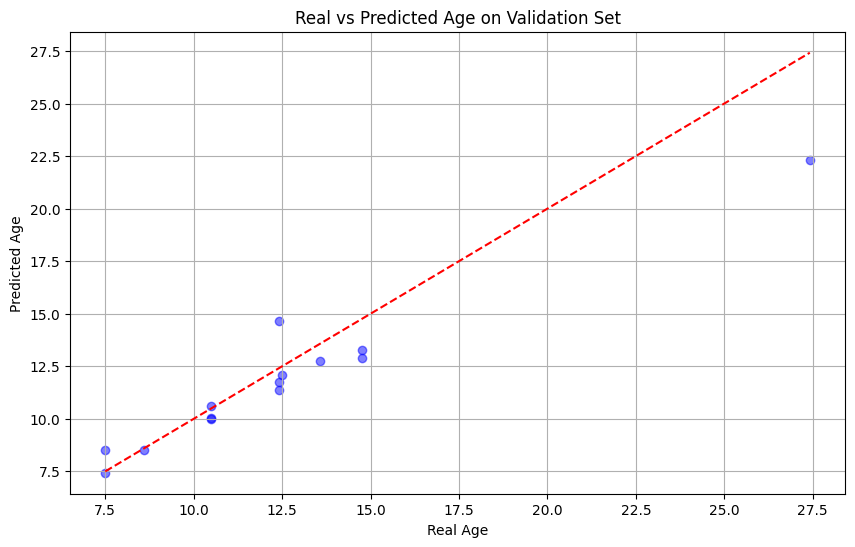

In [18]:
import matplotlib.pyplot as plt

predicted_ages = model.predict([X_test, region_predictions_test, area_test])

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted_ages, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Real Age')
plt.ylabel('Predicted Age')
plt.title('Real vs Predicted Age on Validation Set')
plt.grid(True)
plt.show()
